# cFos Drug Notebook

## Setup

### Switches

In [1]:
## Switch to control whether Batch 1 and Batch 2 datasets are analyzed together. Distinct folders for each style.
batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False
# includeBatch3 = True      # A switch for the merging of the sheets - either include or dont include the Batch 3 data. Also modifies drug list.

# Debug
debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor for mice in batch one.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'svg'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

### Set Initial Paths, Load/Generate Lightsheet df

In [2]:
# Import packages
import os, sys, importlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('functionScripts')
sys.path.append('dependencies')

import initFunctions as init #import createDirs, debugReport, loadLightSheetData
import analysisFunctions #compareAnimals, drug_stats_and_changes, brainRegionTrend
import classifyFunctions  #sclassifySamples, reformatData
import plotFunctions #totalCountsPlot
import helperFunctions

importlib.reload(init)

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] =   rootDir + 'Atlas\\'
dirDict['dataDir'] =    rootDir + 'Data\\'
dirDict['B1'] =         dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =         dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =    dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =         dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA
dirDict['outputFormat'] = switchDir['outputFormat']

# Make directories, and add their strings to the directory dictionary.
dirDict = init.createDirs(rootDir, switchDir, dirDict)

# once directories have been made, merge data across batches and with atlases, then save.
lightsheet_data = init.loadLightSheetData(dirDict, switchDir)

# Save for test scripts and tempDir
lightsheet_data.to_pickle('testScripts//lightsheet_data.pkl')
lightsheet_data.to_pickle(f'{dirDict["tempDir"]}lightsheet_data.pkl')

# Create the Drug list for reference. Sorting doesn't seem to matter atm.
drugList = list(lightsheet_data.drug.unique())
drugListActive = [x for x in drugList if 'SAL' not in x]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Data being loaded...
Execution time in seconds: 0.01


### Plot - Correlation between Individual animals across regions, Trends across regions

In [3]:
# Correlation across 'count'
# analysisFunctions.compareAnimals(lightsheet_data, 'PSI', 'PSI', 'count')

# Correlation across 'cell_density'
# analysisFunctions.compareAnimals(lightsheet_data, 'PSI', 'PSI', 'cell_density')
# analysisFunctions.compareAnimals(lightsheet_data, 'SAL', 'SAL', 'cell_density')

### Trends across brain areas.
# analysisFunctions.brainRegionTrend(lightsheet_data, 'density_norm', 'PSI', 'KET')

In [4]:
remove_list = ['Fibretracts', 'VentricularSystems', 'Cerebellum']
lightsheet_data = lightsheet_data[~lightsheet_data['Brain_Area'].isin(remove_list)]

# Additional Processing
data_diff, combined_stats, data_diff_raw, data_diff_raw_labels = analysisFunctions.drug_stats_and_changes(lightsheet_data, drugList)

# Code for comparing specific contrasts.
# print('Test Stage A')
# data_diff_focused = data_diff.copy()
# data_diff_focused = data_diff_focused[['Region_ID', 'abbreviation', 'Region_Name', 'KET-aSAL', 'aPSI-aSAL']]
# data_diff_focused.to_csv(tempDir + 'data_diff.csv')
# lightsheet_data.to_csv(tempDir + 'lightsheet_data_preFxnNew.csv')
# combined_stats.to_csv(tempDir + 'combined_stats.csv')

if debugOutputs:
    init.debugReport(data_diff, 'data_diff', dirDict['debug_outPath'], 'Region_Name', debug_ROI)
    init.debugReport(combined_stats, 'combined_stats', dirDict['debug_outPath'], 'Region_Name', debug_ROI)
    init.debugReport(data_diff_raw[data_diff_raw_labels == 'aPSI-aSAL'][0], 'aPSI-aSAL', dirDict['debug_outPath'], 'Region_Name', debug_ROI)
    init.debugReport(data_diff_raw[data_diff_raw_labels == 'PSI-SAL'][0], 'PSI-SAL', dirDict['debug_outPath'], 'Region_Name', debug_ROI)

## Classifiction

### Plot - Heatmaps, Corralograms

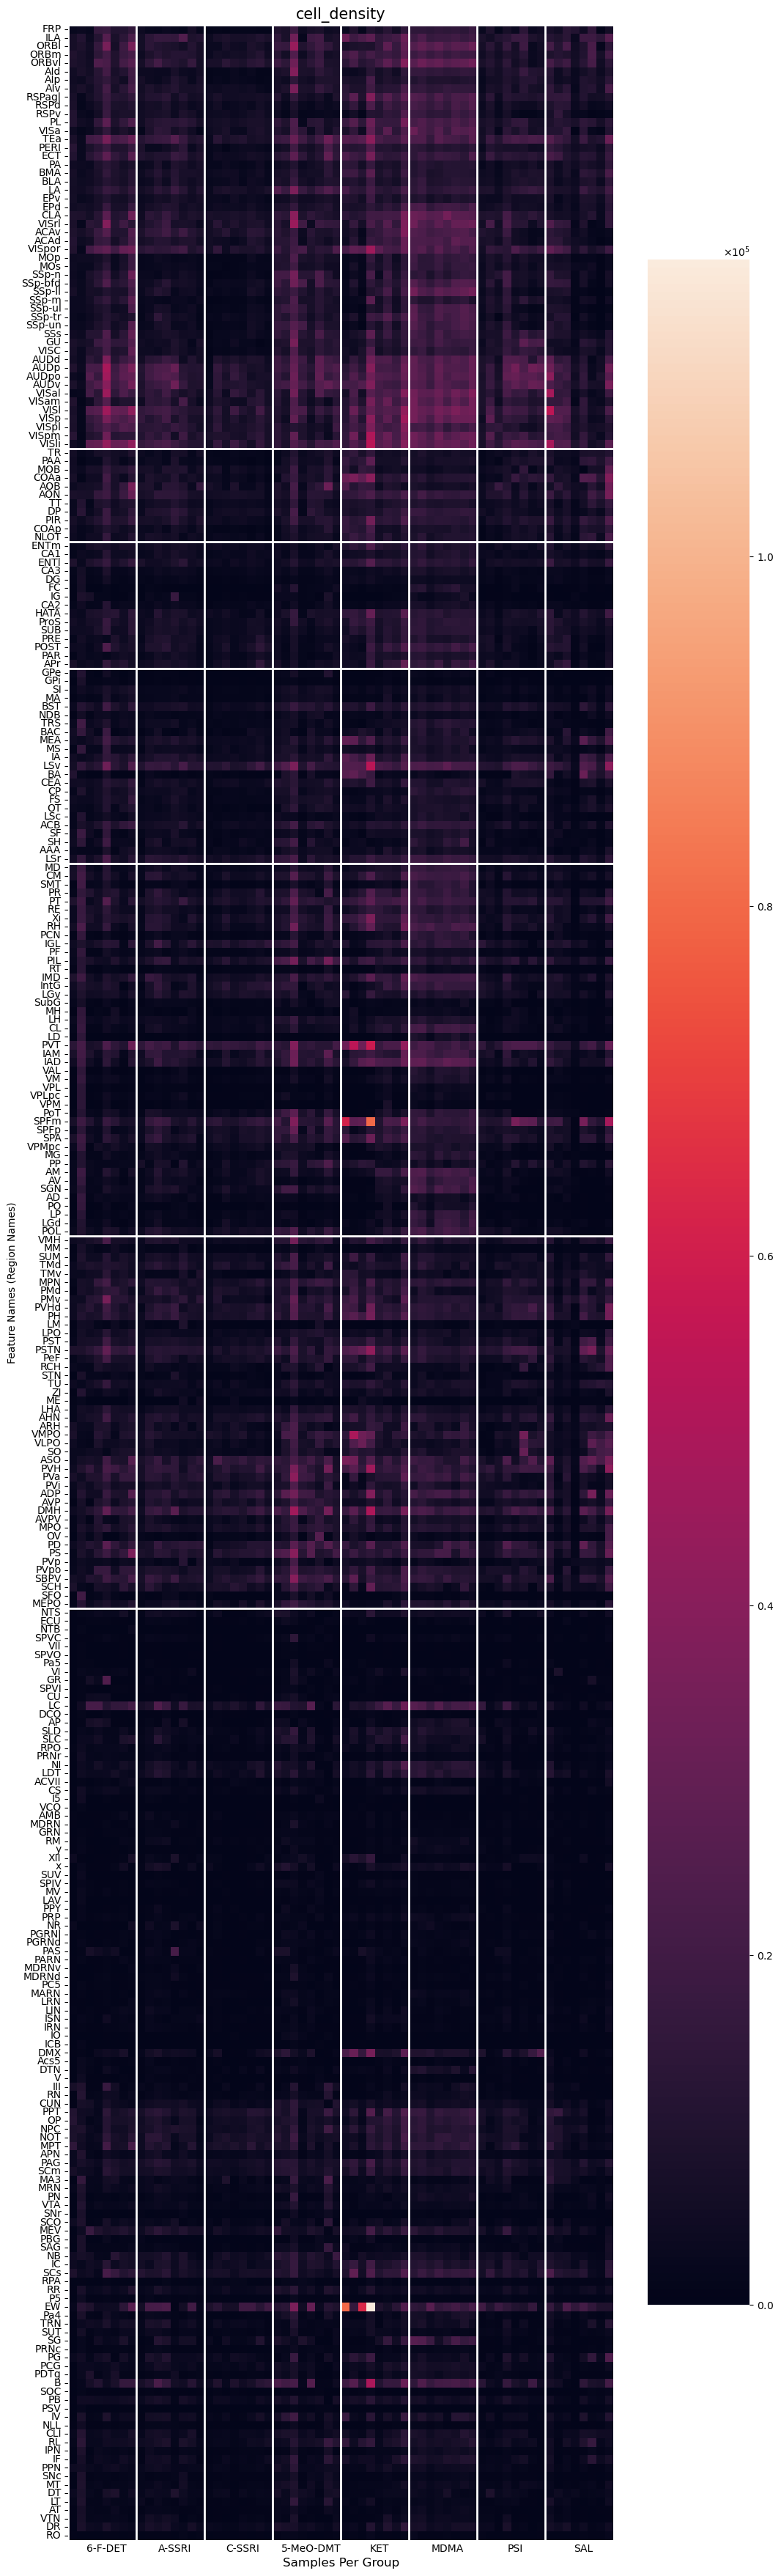

In [5]:
### Functions for plotting data as a heatmap and looking at corralograms
importlib.reload(plotFunctions)

classifyDict = dict()
classifyDict['data'] = 'count_norm' # cell_density, count, count_norm, density_norm
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'drug' #'drug', 'class_5HT2A', 'class_KetPsi', 'class_5HTR', 'class_Trypt', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI' # Defined in 'helperFunctions.create_drugClass_dict'

# Can filter features
#lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)

# Plotting Data
# plotFunctions.data_heatmap(lightsheet_data, 'abbreviation', 'count_norm', dirDict)
plotFunctions.data_heatmap_single(lightsheet_data, 'abbreviation', 'cell_density', dirDict)

# Correlation and distance metrics
# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

### Run the Classifier

In [6]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

# Set a random seed for reproducibility.
np.random.seed(seed = 31415)

# Configure classifyDict to specify analyses
classifyDict = dict()

# Parameters for pivoting the data
classifyDict['data'] = 'count_norm' # cell_density, count, count_norm, density_norm
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'drug' #'drug', 'class_5HT2A', 'class_KetPsi', 'class_5HTR', 'class_Trypt', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI' # Defined in 'helperFunctions.create_drugClass_dict'

# Parameters for feature scaling and aggregation
classifyDict['featurefilt'] = True # True, False
classifyDict['filtType'] = 'min' # Min removes the bottom 1%, Max removes the top 99th percentile.
classifyDict['featureAgg'] = False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster
 
# Parameters for Preprocessing and feature selection
classifyDict['model_featureTransform'] = True   # True, False - applies the Yeo-Johnson power transformation to shift features into more gaussian distributions.
classifyDict['model_featureScale'] = True       # True, False
classifyDict['model_featureSel'] = 'Boruta'     # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_alpha'] = 0.05   # Used for Fdr, Fwe, and Fwe_BH

# If Fdr/Fwe/None are not used for feature selection, the number of k feature must be preset
classifyDict['model_featureSel_mode'] = 'modelPer'      # 'gridCV', 'modelPer'
classifyDict['model_featureSel_k'] = [30]               # [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Parameters for classification
classifyDict['model'] = 'LogRegL2' #'LogRegL2', 'LogRegL1', 'ElasticNet', 'LDA', 'RandomForest'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'
classifyDict['max_iter'] = 100
classifyDict['CVstrat'] = 'ShuffleSplit' #'StratKFold', 'ShuffleSplit'

# ParamGrid Features - in instances where gridCV is set to true, these are the parameters that will be tested.
paramGrid = dict()
paramGrid['classif__l1_ratio'] = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]       # used for ElasticNet
# paramGrid['classif__C'] = [0.001, 0.01, 0.1, 1, 10]                    # used for LogisticRegression
paramGrid['classif__C'] = [1]                                            # used for LogisticRegression
classifyDict['pGrid'] = paramGrid

classifyDict['shuffle'] = False
classifyDict['gridCV'] = False

if classifyDict['CVstrat'] == 'ShuffleSplit':
    classifyDict['CV_count'] = 100 # Number of folds for cross-validation
else:
    # K fold stratified can only afford n_classes of folds
    classifyDict['CV_count'] = 8 

if classifyDict['label'] == 'drug':
    classifyDict['test_size'] = 1/8
    classifyDict['innerFold'] = 7
else:
    classifyDict['test_size'] = 1/4
    classifyDict['innerFold'] = 4

classifyDict['saveLoadswitch'] = True

# An identifer which is added at the start of folders.
dirDict['uniqID'] = 'try100'

# classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)

In [7]:
if debugOutputs:
    # Looking at DR
    lightsheet_data_DR = lightsheet_data.loc[(lightsheet_data.Region_Name == 'Dorsal nucleus raphe')]
    lightsheet_data_DR.to_csv('DorsalRaphe_Lightsheet.csv')

### statistics for changes across brain regions

In [8]:
from scipy.stats import ttest_ind_from_stats
from statsmodels.stats.multitest import fdrcorrection

# Compare each of the drugs to Saline
drug_test = np.empty(len(drugListActive), dtype=object)
drug_pVal = np.empty(len(drugListActive), dtype=object)

for drug_i, drug in enumerate(drugListActive):
    drug_test[drug_i], drug_pVal[drug_i] = ttest_ind_from_stats(mean1=combined_stats[drug + '_average'], std1=combined_stats[drug + '_standard_deviation'], nobs1=combined_stats[drug + '_observations'],
                                                                mean2=combined_stats['SAL_average'],     std2=combined_stats['SAL_standard_deviation'],     nobs2=combined_stats['SAL_observations'],equal_var='False')

drug_test_corrected = np.empty(len(drugListActive), dtype=object)

# sort and fdr correct
for drug_i in range(0, len(drugListActive)):
    drug_test_corrected[drug_i]=fdrcorrection( drug_pVal[drug_i].sort_values(), alpha=0.05, method='indep', is_sorted=True)

# No region comparisons survive multiple comparisons correction.

## Figure Code

In [9]:
### Convert names.
all_cfos = lightsheet_data.copy()
all_cfos_diff = data_diff.copy()

In [12]:
# Find the averages for each drug for each region.
# get averages
# all_cfos_export = all_cfos.groupby(['abbreviation','Region_Name','drug'])['cell_density'].mean().reset_index()

# Convert to a pivot table.
# all_cfos_means_csv = all_cfos_export.pivot(values='cell_density', index='abbreviation', columns='drug')
            
# Export
# all_cfos_means_csv.to_csv(dirDict['outDir'] + 'all_cfos_density_means.csv')
# # Export Average differences across regions (done in original fxn)
# all_cfos_diff.to_csv(dirDict['outDir'] + 'all_cfos_diffs_means.csv')

### Figure 1 - Cell counts across animals, grouped by drug

<Figure size 640x480 with 0 Axes>

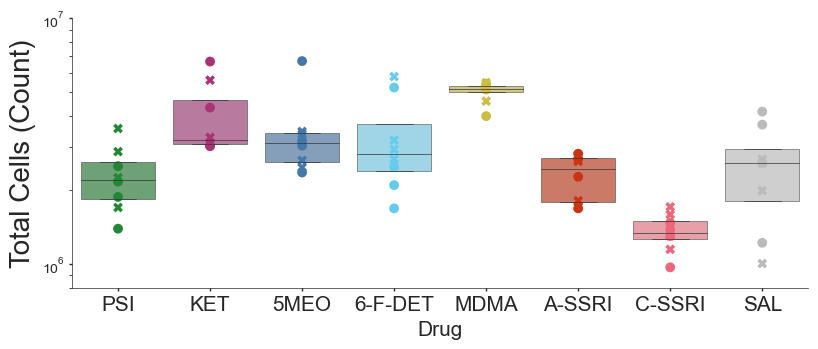

In [13]:
plotFunctions.plotTotalPerDrug(lightsheet_data, 'total_cells', dirDict, outputFormat)

### Figure 2 - Supervised Dim Red via LDA

In [ ]:
plotFunctions.plotLowDimEmbed(lightsheet_data, 'count_norm', dirDict, 'LDA', classifyDict) # 'count_norm', 'total_cells','cell_density'

### Figure ?: All ROIs - Active vs Saline

In [ ]:
# Recreate this variable

#filter data
# cleaned_all_cfos_diff = all_cfos_diff.query("Region_Name not in @excluded_regions")
cleaned_all_cfos_diff = data_diff_raw
cleaned_all_cfos_diff_labels = data_diff_raw_labels

#plotting
fileOutName = dirDict['outDir'] + 'fig2_deltaPerRegion_' + 'SAL.' + outputFormat

if not os.path.exists(fileOutName):
    #sns.set(font_scale = 1)
    sns.set(style='ticks',font_scale=8)
    plt.figure(figsize=(50,400))
    drugPairList = [(a + '-'+ b) for idx, a in enumerate(drugList) for b in drugList[idx + 1:]]
    palette = sns.color_palette(n_colors=len(drugList))

    for drug_comp_i in range(0, len(cleaned_all_cfos_diff)):
        #melt data for plotting and specify color
        data = pd.melt(cleaned_all_cfos_diff[drug_comp_i], id_vars=['Region_Name'], value_vars=drugPairList[drug_comp_i],
                        var_name='Drug', value_name='Change')
        if drug_comp_i == 0:
            data_melted = data
        else:
            data_melted = pd.concat([data_melted, data], ignore_index=True, sort=False)

    # Focus on the comparisons involving SAL condition
    drugDataMelt = data_melted[data_melted.Drug.str.contains('SAL')]

    #point plot
    ax = sns.pointplot(y='Region_Name', x='Change', data = drugDataMelt, errorbar=('ci', 95), join=False, units=16, errwidth = 0.5,
                    hue='Drug', palette = palette, dodge=0.4, scale=3)

    #cleanup
    sns.despine()
    plt.xlabel('cFos density change (%)')
    plt.ylabel('')

    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.set_tick_params(length=40, width=0.5)
    ax.yaxis.set_tick_params(length=0, width=0.0)
    plt.axvline(x=0, color='grey', linestyle='--', lw=0.5)

    fig = plt.savefig(fileOutName, format=outputFormat, bbox_inches='tight')


In [ ]:
#move data for plotting
heatmap_data = pd.pivot_table(all_cfos, values='cell_density', 
                              index=['abbreviation'], 
                              columns='dataset')
heatmap_data.dropna(how='any', inplace=True)

#plot
sns.set_style("white")
sns.set(font_scale = 2)

# Find Brain areas
brainAreaList = all_cfos.Brain_Area.unique()
area2Region = dict(zip(all_cfos.abbreviation, all_cfos.Brain_Area))
brainAreaPalette = sns.color_palette(n_colors=len(brainAreaList))
rowColDict = dict(zip(brainAreaList, brainAreaPalette))
row_colors = all_cfos.Brain_Area.map(rowColDict)

drugColorPalette = sns.color_palette(n_colors=len(drugList))


ax = sns.clustermap(heatmap_data, cmap='coolwarm', standard_scale=1, 
                    method='average', metric='correlation', tree_kws=dict(linewidths=10),
                    yticklabels=True, figsize=(120,120), row_colors=list(row_colors)) #col_colors=row_colors
plt.savefig(dirDict['outDir'] + 'hierarchical_cluster_summary_structs.svg',  format='svg', bbox_inches='tight')
plt.show()
# Columns of dataset may need to be rearranged to make heat map intelligable.

### Collecting CI's for Drug - Sal conditions

In [ ]:
# Collect the confidence intervals for the prior
if batchSplit:
    # More complicated to focus on aSAL vs SAL for the right drugs.
    drugListA = [x for x in drugList if x[0] == 'a']
    drugListB = [x for x in drugList if x[0] != 'a']
    drugPairListA = [(a + '-'+ b) for idx, a in enumerate(drugListA) for b in drugListA[idx + 1:]]
    drugPairListB = [(a + '-'+ b) for idx, a in enumerate(drugListB) for b in drugListB[idx + 1:]]
    drugPairList = drugPairListA + drugPairListB

    # Brief additional processing to make sure Batch 1 is processed w/ batch 1 saline (aSAL)
    salListA = [i for i in drugPairListA if 'SAL' in i]
    salListB = [i for i in drugPairListB if 'SAL' in i]
    salList = salListA + salListB

else:
    drugPairList = [(a +'-'+ b) for idx, a in enumerate(drugList) for b in drugList[idx + 1:]]
    salList = [i for i in drugPairList if 'SAL' in i]

# Generate some structures to load.
drug_ci_range = np.empty((len(drugListActive),2), dtype=object)
drug_ci_range_drugList = np.empty((len(drugListActive),1), dtype=object)

# Define Paths
tmpFileName = 'drug_ci_range_db_utils.h5.npy'
tempDataFilename = dirDict['tempDir'] + tmpFileName

if os.path.exists(tempDataFilename):
    print('Loading ' + tmpFileName + '...')

    # Load previous saved file
    ciRangeDB = pd.read_pickle(tempDataFilename)

else:
    print('Generating ' + tmpFileName + '...')

    for idx, drugPair in enumerate(tqdm(salList)):
        
        dataInd = list(cleaned_all_cfos_diff_labels).index(drugPair)

        # Make life easier - collect needed dots
        regionList = cleaned_all_cfos_diff[dataInd].Region_Name.unique()
        dataCol = cleaned_all_cfos_diff_labels[dataInd]
        dataTable = cleaned_all_cfos_diff[dataInd]
        ciData = np.empty([len(regionList), 2])

        # Two methods for determining CIs. Method 2 is faster, and seems to yield identical responses.
        methodSwitch = 2

        if methodSwitch == 1:
        # Method 1 - Sure about region/number match - very slow.
            for region_i, region in enumerate(regionList):
                regionData = dataTable.loc[dataTable.Region_Name == region][dataCol]
                ciData[region_i, :] = sns.utils.ci(sns.algorithms.bootstrap(regionData), which=95)

            if idx == 0:
                ciRangeDB = pd.DataFrame()
                ciRangeDB['Region_Name'] = regionList

            ciRangeDB[drugPair + '_lower'] = ciData[:,0]
            ciRangeDB[drugPair + '_upper'] = ciData[:,1]

        elif methodSwitch == 2:
        # Method 2 - Plot it, things are done faster.
            # Figure
            plt.figure(figsize=(50,400))

            ax = sns.pointplot(y='Region_Name', x=dataCol, data = dataTable, errorbar=('ci', 95), join=False, units=16, errwidth = 0.5, color='red',dodge=True)

            # Pull values
            if idx == 0:
                ciRangeDB = pd.DataFrame()
                ciRangeDB['Region_Name'] = [textObj.get_text() for textObj in ax.axes.get_yticklabels()]

            ciRangeDB[drugPair + '_upper'] = [line.get_xdata().max() for line in ax.lines]
            ciRangeDB[drugPair + '_lower'] = [line.get_xdata().min() for line in ax.lines]
            plt.clf()

    # Save for later use
    ciRangeDB.to_pickle(tempDataFilename)  

### Fig 3: Drug Delta Paired comparisons.

In [ ]:
# Hand selected ROIs for comparison
all_selected_ROI = [39, 48, 972, 104, 961, 44, #most of cortex
                    385, 425, 402, 533, 394, #visual areas
                    879, 886, 894, #retrosplenial
                    147, 583, 536, 295, 319, # amygdala
                    255, 64, 59, 362, 262, #thalamus
                    672, 795, 1048, #subcortical significant
                    872, 238, 206, 230, 222, #raphe
                    351, 382, 463, 502, #ketamine subcortical
                    56, 749] #subcortical non significant

### Scatterplots comparing changes from baseline (saline) between two drugs.

In [ ]:
import math

#get data
# quadrant_compare = cleaned_all_cfos_diff #cleaned_s2p_diff #cleaned_all_cfos_diff 
# quadrant_compare = quadrant_compare.groupby(['Region_Name','abbreviation'],sort=False)[drugB + 'sal',drugB + 'ket','ket-sal'].mean().reset_index()
# quadrant_compare_select = quadrant_compare_select.groupby(['Region_Name','abbreviation'])[drugB + 'sal',drugB + 'ket','ket-sal'].mean().reset_index() # Means taken before.

# Match the table generated for confidence intervals and the quadrant_compare.
quadrant_compare = data_diff.copy()        # groupby procedure done in 'drug_changes' fxn.
corLabels = ['Region_ID', 'abbreviation', 'Region_Name'] + [x for x in quadrant_compare.columns if x.__contains__('SAL')]
quadrant_compare = quadrant_compare[corLabels]
quadrant_compare_ci = ciRangeDB.merge(quadrant_compare, on='Region_Name', how='inner', suffixes=('', '_x'))

# Comparing drug changes of drug vs saline, plot comparisons which may be interesting - A-SSRI vs PSI, DMT vs PSI, A-SSRI vs C-SSRI, DMT vs 6-F-DET
drugComparisons = [['PSI-SAL', 'A-SSRI-SAL'], ['PSI-SAL', '5MEO-SAL'], ['PSI-SAL', 'MDMA-SAL'], ['A-SSRI-SAL', 'C-SSRI-SAL'], ['5MEO-SAL', '6-F-DET-SAL']]

if batchSplit:
    drugComparisons = drugComparisons + [['aPSI-aSAL', 'aKET-aSAL'], ['PSI-SAL', 'cKET-SAL'], ['aKET-aSAL', 'cKET-SAL'], ['aPSI-aSAL', 'PSI-SAL']]
else:
    drugComparisons = drugComparisons + [['PSI-SAL', 'KET-SAL']]

if testSplit:
    drugComparisons = drugComparisons + [['C-SSRI_t-SAL', 'C-SSRI-SAL'], ['5MEO_t-SAL', '5MEO-SAL']]

for drug_comp_i in range(0,len(drugComparisons)):
    drugA = drugComparisons[drug_comp_i][0]
    drugB = drugComparisons[drug_comp_i][1]
    drugAname = drugA.replace('-SAL','').replace('-aSAL','')
    drugBname = drugB.replace('-SAL','').replace('-aSAL','')
    drugPair = drugAname + '_' + drugBname
    sigColName = drugPair + ' significant'
    LabelArray = ['Both ' + drugAname + ' and ' + drugBname + ' outside 95% CI, same dirr',
                  'Both ' + drugAname + ' and ' + drugBname + ' outside 95% CI, diff dirr',
                  drugAname + ' outside 95% CI', 
                  drugBname + ' outside 95% CI', 'Neither ' + drugAname + ' and ' + drugBname + ' outside 95% CI'] # DrugA and B not Sig, Drug A sig, Drug B sig, Drug A and B Sig

    drugAInd = salList.index(drugA)
    drugBInd = salList.index(drugB)
    
    quadrant_compare_ci[drugA + '_above'] = np.logical_and(quadrant_compare_ci[drugA + '_upper'] > 0, quadrant_compare_ci[drugA + '_lower'] > 0)  # Drug A Above
    quadrant_compare_ci[drugA + '_below'] = np.logical_and(quadrant_compare_ci[drugA + '_upper'] < 0, quadrant_compare_ci[drugA + '_lower'] < 0)  # Drug A Below
    quadrant_compare_ci[drugB + '_above'] = np.logical_and(quadrant_compare_ci[drugB + '_upper'] > 0, quadrant_compare_ci[drugB + '_lower'] > 0)  # Drug B Above
    quadrant_compare_ci[drugB + '_below'] = np.logical_and(quadrant_compare_ci[drugB + '_upper'] < 0, quadrant_compare_ci[drugB + '_lower'] < 0)  # Drug B Below
    quadrant_compare_ci[sigColName] = None

    #calculate
    for index, row in quadrant_compare_ci.iterrows():
        #both drugs positive, same direction, purple
        if (row[drugA + '_above']) and (row[drugB + '_above']) or (row[drugA + '_below']) and (row[drugB + '_below']):
            quadrant_compare_ci.at[index, sigColName] = LabelArray[0]
        #both drugs positive, different directions, pink
        elif ((row[drugA + '_above']) or (row[drugB + '_above'])) and ((row[drugA + '_below']) or (row[drugB + '_below'])):
            quadrant_compare_ci.at[index, sigColName] = LabelArray[1]
        # only drug A changes, blue
        elif (row[drugA + '_above']) or (row[drugA + '_below']):
            quadrant_compare_ci.at[index, sigColName] = LabelArray[2]
        # only drug B changes, red
        elif (row[drugB + '_above']) or (row[drugB + '_below']):
            quadrant_compare_ci.at[index, sigColName] = LabelArray[3]
        # Neither drug drives sig change, grey
        else:
            quadrant_compare_ci.at[index, sigColName] = LabelArray[4]
            
    
    # Test Stage B
    # ciRangeDB_drugCopy = quadrant_compare_ci[['Region_Name', drugA + '_lower', drugA + '_upper', drugB + '_lower', drugB + '_upper']]
    # ciRangeDB_drugCopy[drugA + '_above'] = quadrant_compare_ci[drugA + '_above']
    # ciRangeDB_drugCopy[drugA + '_below'] = quadrant_compare_ci[drugA + '_below']
    # ciRangeDB_drugCopy[drugB + '_above'] = quadrant_compare_ci[drugB + '_above']
    # ciRangeDB_drugCopy[drugB + '_below'] = quadrant_compare_ci[drugB + '_below']
    # ciRangeDB_drugCopy[sigColName] = quadrant_compare_ci[sigColName]
    # ciRangeDB_drugCopy.to_csv(outDir + 'ciTable_' + drugPair + '.csv')

    # quadrant_compare.loc[quadrant_compare[sigColName] == 'purple'].tail(60)

### Table of ROI values, in Word

In [ ]:
# Connsider swapping for https://chartio.com/learn/charts/heatmap-complete-guide/

import docx
from docx.shared import Inches

all_selected_ROI_clustered = [[[39, 48, 972, 104, 961, 44], 'Ctx'], #most of cortex
                    [[385, 425, 402, 533, 394], 'Visual Ctx'], #visual areas
                    [[879, 886, 894], 'Retrosplenial Ctx'], #retrosplenial
                    [[147, 583, 536, 295, 319], 'Amygdala'], # amygdala
                    [[255, 64, 59, 362, 262], 'Thalamus'], #thalamus
                    [[672, 795, 1048], 'Subcort Nuclei'], #subcortical significant
                    [[872, 238, 206, 230, 222], 'Raphe'], #raphe
                    [[351, 382, 463, 502], 'Subcort - Ket ROI'], #ketamine subcortical
                    [[56, 749], 'Subcort - Other']] #subcortical non significant

styleList = ['Colorful Shading Accent ' + str(x+1) for x in np.arange(6)] + ['Medium Shading 2 Accent ' + str(x+1) for x in np.arange(6)]

# Check - https://www.geeksforgeeks.org/working-with-tables-python-docx-module/

# Create a table for comparing across the drug classes
keepInd = data_diff.columns.str.contains('-SAL')
keepInd[0:3] = True
all_drug_table = data_diff.loc[:, keepInd]

# Filter based on regions of interest
all_drug_table = all_drug_table[all_drug_table['Region_ID'].isin(all_selected_ROI)]
all_drug_table = round(all_drug_table,2)

# Create an instance of a word document
doc = docx.Document()
doc.add_heading('Drug effect on Regions', 0)

tableArray = []
rowElements = []

for table_i, table_data in enumerate(all_selected_ROI_clustered):

    # Creating a table object
    table = doc.add_table(rows=1, cols=len(drugListActive)+1)
    
    # Create the top row - 1st Col = Name of set of groups, after that, active drugs.
    row = table.rows[0].cells
    row[0].text = all_selected_ROI_clustered[table_i][1]
    regionList = all_selected_ROI_clustered[table_i][0]

    for ind, drug in enumerate(drugListActive):
        row[ind+1].text = drug

    # Pull Cluster specific data out of the table
    clusterDrugData = all_drug_table.loc[all_drug_table.Region_ID.isin(table_data[0]), :]
    clusterDrugData = clusterDrugData.drop(columns=['Region_ID', 'Region_Name'])

    for row_i in np.arange(clusterDrugData.shape[0]):
        row = table.add_row().cells
        for table_i in np.arange(clusterDrugData.shape[1]):
            row[table_i].text = str(clusterDrugData.iloc[row_i, table_i])

    tableArray.append(table)
    p = doc.add_paragraph('a break')

# Styles overwritten when added elsewhere
for table_i, table in enumerate(tableArray):
    tableArray[table_i].style = styleList[table_i]

# Now save the document to a location
doc.save(dirDict['outDir'] + 'ROI_Tables.docx')

In [ ]:
# Write a function to label points

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    textArray = []
    for i, point in a.iterrows():
        textArray.append(ax.text(point['x']+0.4, point['y']+0.4, str(point['val'])))

    return textArray

### Compare Drug Effects via Scatter plots

In [ ]:
# Consider Adding Squares to denote significant regions - https://datavizpyr.com/how-to-draw-a-rectangle-on-a-plot-in-matplotlib/

from adjustText import adjust_text
from matplotlib import cm
from itertools import chain

quadrant_compare = quadrant_compare_ci.copy()
quadrant_compare = round(quadrant_compare,2)

#plot
sns.set(font_scale = 4)
sns.set_style("ticks")
plt.figure(figsize=(20,20))

#select regions (same as before)
all_select = all_selected_ROI
quadrant_compare_select = quadrant_compare[quadrant_compare['Region_ID'].isin(all_select)]

# Color coding block - generate a color code for the labels of a region, based on which larger cluster it belongs to
regionNameList = [x[1] for x in all_selected_ROI_clustered]
regionColorMap = cm.get_cmap('Set1')
regionColorList = regionColorMap([np.arange(len(all_selected_ROI_clustered))])
regionColorList = regionColorList[0]
colorLabelDict = {k:v for k,v in zip(regionNameList, regionColorList)}

regionListTiled = [len(x[0]) * [x[1]] for x in all_selected_ROI_clustered]
regionListTiled = list(chain.from_iterable(regionListTiled))
regionListColor = [colorLabelDict[x] for x in regionListTiled]

regionIDList = [x[0] for x in all_selected_ROI_clustered]
regionIDList = list(chain.from_iterable(regionIDList))
colorLabelDict = {k:v for k,v in zip(regionIDList, regionListColor)}

quadrant_compare_select['textColor'] = quadrant_compare_select.Region_ID.map(colorLabelDict)

colorPalletDict = {'Neither ' + drugAname + ' and ' + drugBname + ' outside 95% CI': 'grey', # DrugA and B not Sig, Drug A sig, Drug B sig, Drug A and B Sig
            'Both ' + drugAname + ' and ' + drugBname + ' outside 95% CI, same dirr': 'purple',
            'Both ' + drugAname + ' and ' + drugBname + ' outside 95% CI, diff dirr': 'pink',
            drugAname + ' outside 95% CI' : 'red', 
            drugBname + ' outside 95% CI' : 'blue'}

plotNameDict = {'KET': 'Ketamine', 'aKET': 'Ketamine (B1)', 'cKET': 'Ketamine (B3)', 'PSI': 'Psilocybin', 'aPSI': 'Psilocybin (B1)', 
                'A-SSRI': 'Acute SSRI', 'C-SSRI': 'Chronic SSRI', 'C-SSRI_t': 'Chronic SSRI (T1)', 
                'DMT': 'Dimethyltryptamine (DMT)', 'DMT_t': 'Dimethyltryptamine (DMT) (T1)', '6-F-DET': '6-Flouro-Diethyltryptamine (6-F-DET)', 
                'MDMA': '3,4 - MDMA'}
# colorPalletDict = dict(purple="purple", red="red",blue="blue", grey = "grey")

# Nest the loop to generate graphs which focus on the selected ROIs
subSetPlotTitles = ('All', 'Select')
subSetPlotAlphas = (0.5, 0.1)             # Alphas used for other data
subSetPlotAxes = [[-100,407], [-100,200]]

# subSetPlotTitles = [('Select')]
# subSetPlotAlphas = [(0.1)]             # Alphas used for other data
# subSetPlotAxes = [[-100,200]]

for subPlot_i, subPlotName in enumerate(subSetPlotTitles):
    for drug_comp_i in range(0,len(drugComparisons)):

        # Unpack the variable and process the names
        drugA = drugComparisons[drug_comp_i][0]
        drugB = drugComparisons[drug_comp_i][1]
        drugAname = drugA.replace('-SAL','').replace('-aSAL','')
        drugBname = drugB.replace('-SAL','').replace('-aSAL','')
        drugPair = drugAname + '_' + drugBname
        sigColName = drugPair + ' significant'

        print('Processing ' + subPlotName + ' ' + drugPair)

        # Generate the items to be used for Hue and Legends
        colorPalletDict = {'Neither ' + drugAname + ' and ' + drugBname + ' outside 95% CI': 'grey', # DrugA and B not Sig, Drug A sig, Drug B sig, Drug A and B Sig
                    'Both ' + drugAname + ' and ' + drugBname + ' outside 95% CI, same dirr': 'purple',
                    'Both ' + drugAname + ' and ' + drugBname + ' outside 95% CI, diff dirr': 'pink',
                    drugAname + ' outside 95% CI' : 'red', 
                    drugBname + ' outside 95% CI' : 'blue'}
        hueOrder = list(colorPalletDict.keys())

        #get outliers
        quadrant_compare_outliers = quadrant_compare.loc[(quadrant_compare[drugA]>=400) | (quadrant_compare[drugB] >= 400)]

        # Plotting
        
        # add most of data
        ax = sns.scatterplot(x=drugA, y=drugB, data=quadrant_compare,s=300, hue=sigColName, hue_order = hueOrder, 
                            palette=colorPalletDict, alpha=subSetPlotAlphas[subPlot_i], linewidth=0)
        
        # Modify the Legend
        sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False, markerscale=4, fontsize='small')

        # add select data for labels
        if subPlotName == 'Select':
            ax = sns.scatterplot(x=drugA, y=drugB, data=quadrant_compare_select,s=350, hue=sigColName, hue_order = hueOrder, 
                        palette=colorPalletDict, alpha=1, linewidth=0, legend=False)
        else:
            ax = sns.scatterplot(x=drugA, y=drugB, data=quadrant_compare_select, #use either quadrant_compare_select or quadrant_compare_outliers
                            s=300, color='black', linewidth=0, legend=False)
        
        # sns.scatterplot(data=df, x='x', y='y', hue="cat", marker="$\circ$", ec="face", s=100)

        #do labeling:
        a = pd.concat({'x': quadrant_compare_select[drugA], 'y': quadrant_compare_select[drugB], 'val': quadrant_compare_select['abbreviation'], 'color': quadrant_compare_select['textColor']}, axis=1)
        textArray = []
        if subPlotName == 'All':
            for i, point in a.iterrows():
                textArray.append(ax.text(point['x']+0.4, point['y']+0.4, str(point['val'])))
        else:
            for i, point in a.iterrows():
                textArray.append(ax.text(point['x']+0.4, point['y']+0.4, str(point['val']), color=point['color']))

            # Add Labels for the colors, first find the starting location
            spacing = -14
            xVal = subSetPlotAxes[subPlot_i][1]
            yValVec = np.arange(xVal, xVal+spacing*9, spacing)
            for (regionLabel, regionColor, yVal) in zip(regionNameList, regionColorList, yValVec):
                ax.text(xVal + 30, yVal, regionLabel, color=regionColor)


        ## 
        sns.despine()
        plt.xlabel(plotNameDict[drugAname] + ' cell density change (%)')
        plt.ylabel(plotNameDict[drugBname] + ' cell density change (%)')
        plt.axvline(x=0, linewidth=0.5, color='grey', linestyle='--')
        plt.axhline(y=0, linewidth=0.5, color='grey', linestyle='--')

        # plt.yscale('symlog')
        # plt.xscale('symlog')
        plt.axis('equal')

        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.xaxis.set_tick_params(length=40, width=0.5)
        ax.yaxis.set_tick_params(length=40, width=0.5)
    
        plt.xlim(subSetPlotAxes[subPlot_i])
        plt.ylim(subSetPlotAxes[subPlot_i])

        adjust_text(textArray, arrowprops=dict(width=1, headwidth=1, headlength=1, color='grey'))

        # if subPlotName == 'Select':
        #     # Add Labels for the colors, first find the starting location
        #     xVal = subSetPlotAxes[subPlot_i][1] - 10
        #     yValVec = np.arange(xVal, xVal+10*9, 10)
        #     for (regionLabel, regionColor, yVal) in zip(regionNameList, regionColorList, yValVec):
        #         ax.text(xVal, yVal, regionLabel, color=regionColor)

        plt.savefig(dirDict['outDir'] + drugPair + '_compare_' + subPlotName + '.' + outputFormat,  format=outputFormat,  bbox_inches='tight')
        plt.savefig(dirDict['outDir'] + drugPair + '_compare_' + subPlotName + '.svg',  format='svg',  bbox_inches='tight')
        plt.clf()

## mRNA vs cFos

In [ ]:
#load data
all_gene_data = pd.read_csv(dirDict['atlasDir'] + "allGeneStructureInfo_allgenes_summary_struct.csv")

#first get mean and sd by gene across whole brain

#clean up a little first

#getting structure averages
all_gene_data_clean = all_gene_data.drop(columns=['Unnamed: 0', 'data_set_id', 'plane_of_section_id'])
StructureAverages = all_gene_data_clean.groupby(['structure_id','gene_acronym']).mean().reset_index()
# StructureAverageDensity = StructureAverage.groupby(['structure_id', 'gene_acronym']).mean().reset_index() # Two tables were identical, double check if done correctly FAQ
# StructureAverages = pd.merge(StructureAverageEnergy, StructureAverageDensity)

#averaging across whole brain
all_gene_data_clean = all_gene_data_clean.drop(columns=['structure_id'])
GeneAverageEnergy = all_gene_data_clean.groupby('gene_acronym').agg({'expression_energy': ['mean', 'std']}).reset_index()
GeneAverageDensity = all_gene_data_clean.groupby('gene_acronym').agg({'expression_density': ['mean', 'std']}).reset_index()
GeneAverages = pd.merge(GeneAverageEnergy, GeneAverageDensity)

#calculate zscore for each brain structure
#fresh copy of structure data
ZscoreStructure = StructureAverages.copy()
ZscoreStructure = ZscoreStructure.merge(GeneAverages, how='left', left_on='gene_acronym', right_on='gene_acronym')

#rename columns for clarity
column_indices = [4,5,6,7]
new_names = ['brain_expression_energy_mean','brain_expression_energy_std','brain_expression_density_mean','brain_expression_density_std']
old_names = ZscoreStructure.columns[column_indices]
ZscoreStructure = ZscoreStructure.rename(columns=dict(zip(old_names, new_names)))

#calculate zscore with structure/gene average and brain wide gene average/std
ZscoreStructure['zscore'] = (ZscoreStructure['expression_energy'] - ZscoreStructure['brain_expression_energy_mean']) / (ZscoreStructure['brain_expression_energy_std'])

### add Allen IDs and structures to data

In [ ]:
#get allen names
remove_list = ['Fibretracts', 'VentricularSystems']
hierarchy_meso_ids = hierarchy_meso[~hierarchy_meso['Brain Area'].isin(remove_list)]
hierarchy_meso_ids = hierarchy_meso_ids.rename(columns={'id':'Region_ID', 'full structure name': 'Region_Name'})
hierarchy_meso_ids = hierarchy_meso_ids.drop(columns=['Major Division', 'summary_struct'])

#rename/clean for matching
ZscoreStructure = ZscoreStructure.rename(columns={'structure_id':'Region_ID'})
ZscoreStructure = ZscoreStructure.drop(columns=['expression_energy','expression_density','brain_expression_energy_mean','brain_expression_energy_std','brain_expression_density_mean', 'brain_expression_density_std'])

#merge
ZscoreStructure = ZscoreStructure.merge(hierarchy_meso_ids, on='Region_ID', how='inner', suffixes=('', '_x'))
ZscoreStructure = ZscoreStructure.drop(ZscoreStructure.filter(regex='_x$').columns.tolist(),axis=1)

### Load mRNA data

In [ ]:
# Look at data
data_diff.head()

In [ ]:
#mRNA
ZscoreStructure

#cFos
cfos_all = data_diff
# cfos_all = cfos_all.groupby(['Region_Name','abbreviation','Region_ID'])['psi-sal','psi-ket','ket-sal'].mean().reset_index() # Done prior
cfos_all = cfos_all.merge(hierarchy_meso_ids, on='abbreviation')
cfos_all = cfos_all.rename(columns={'Region_Name_x':'Region_Name', 'Region_ID_x':'Region_ID'})
cfos_all = cfos_all.drop(columns={'Region_ID_y','Region_Name_y'})
cfos_x_genes = cfos_all.merge(ZscoreStructure, on=['Region_ID','abbreviation','Brain Area'])
cfos_x_genes = cfos_x_genes.rename(columns={'Region_Name_x':'Region_Name'})
cfos_x_genes = cfos_x_genes.drop(columns='Region_Name_y')

#matrices
# cfos_matrix_psi = cfos_x_genes.pivot(values='psi-sal',index='gene_acronym', columns='Region_Name') #psilocybin
# cfos_matrix_ket = cfos_x_genes.pivot(values='ket-sal',index='gene_acronym', columns='Region_Name') #ketamine
gene_matrix = cfos_x_genes.pivot(values='zscore',index='gene_acronym', columns='Region_Name')

In [ ]:
ZscoreStructure

selected_receptors = ['Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5',
            'Gria2', 'Grik2','Grin2b',
            'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2', 'Drd3', 'Oprm1']

zscore_select = ZscoreStructure[ZscoreStructure['gene_acronym'].isin(selected_receptors)]
zscore_select.to_csv(dirDict['outDir'] + 'genes_of_interest_whole_brain.csv')

### All gene x structure correlation (Both brain wide and cortex)

In [ ]:
cfos_x_genes_ctx = cfos_x_genes[cfos_x_genes['Brain Area'] == 'Cortex']

regionSet = ['brain', 'ctx']
list_of_genes = cfos_x_genes.gene_acronym.unique()

# List of genes shortening for testing loop
# list_of_genes = list_of_genes[0:9]

gene_count = len(list_of_genes)
gene_drug_corr = np.empty([len(drugListActive), len(regionSet)], dtype=object)

for set_i, set_name in enumerate(regionSet):
    for drug_i, drug in enumerate(drugListActive):

        all_correlations = np.empty([gene_count])
        tempDataFilename = dirDict['tempDir'] + drug + '_' + set_name + '_corr_db.h5'

        if os.path.exists(tempDataFilename):
            print('Loading  ' + set_name + ' ' + drug + '...')

            # Load previous saved file
            all_correlations = pd.read_pickle(tempDataFilename)
            
        else:
            print('Processing ' + set_name + ' ' + drug + '...')

            if drug[0] == splitTag[0]:
                drugCol = drug + '-' + 'aSAL'
            else:
                drugCol = drug + '-SAL'

            # Based on the desired comparison, use different datasets
            if set_name == 'ctx':
                cfos_data_genes = cfos_x_genes_ctx
            else:
                cfos_data_genes = cfos_x_genes

            # Iterate across genes, finding correlations
            for gene_i, gene in enumerate(tqdm(list_of_genes)):
                cfos_x_genes_of_interest = cfos_data_genes[cfos_data_genes['gene_acronym'] == gene]
                correlation = cfos_x_genes_of_interest['zscore'].corr(cfos_x_genes_of_interest[drugCol])
                all_correlations[gene_i] = correlation
            
            all_correlations = pd.DataFrame(np.column_stack((list_of_genes, all_correlations)), columns=['gene', drug + ' correlation'])

            # Save for later use
            all_correlations.to_pickle(tempDataFilename)  
            
        gene_drug_corr[drug_i, set_i] = all_correlations


In [ ]:
#list genes of interest for correlation
geneList = ['Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5', 'Slc17a7', 'Plxnd1', 'Fezf2', 'Gad1', 'Camk2a', 
            'Gria2', 'Grik2','Grin2b',
            'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2', 'Drd3', 'Oprm1']

for set_i, set in enumerate(regionSet):
    for drug_i, drug in enumerate(drugListActive):

        drug_data = gene_drug_corr[drug_i, set_i]
        
        #Sort the correlations for each drug
        colData = drug_data[drug + ' correlation']
        drug_data['percentile'] = colData.rank(pct = True)
        drug_data = drug_data.sort_values(by=['percentile'], ascending=False)

        gene_drug_corr[drug_i, set_i] = drug_data

        genes_of_interest = drug_data[drug_data['gene'].isin(geneList)]
        genes_of_interest.to_csv(dirDict['outDir'] + drug + '_' + set + '_genes_of_interest.csv')

### Fig 4C: Cortex x Receptors

In [ ]:

exportFormat = 'png' # can also be 'svg'
plotNameDict = {'KET': 'Ketamine', 'aKET': 'Ketamine (B1)', 'cKET': 'Ketamine (B3)', 'PSI': 'Psilocybin', 'aPSI': 'Psilocybin (B1)', 
                'A-SSRI': 'Acute SSRI', 'C-SSRI': 'Chronic SSRI', 
                'DMT': '5-MeO-Dimethyltryptamine (5MEO)', '6-F-DET': '6-Flouro-Diethyltryptamine (6-F-DET)', 'MDMA': '3,4 - MDMA'}
    
receptorPlotList = ['Htr1a','Htr2a','Htr2b','Htr2c', # 'Htr1b','Htr1d','Htr1f', 'Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7','Slc6a4',
            #'Pvalb', 'Sst', 'Vip', 'Sncg', 'Lamp5', 'Slc17a7', 'Plxnd1', 'Fezf2', 'Gad1', 'Camk2a', 
            'Gria2','Grin2b', #, 'Grik2'
            #'Adra2a', 'Adra2b', 'Hrh1', 
            'Drd1', 'Drd2'] #, 'Drd3', 'Oprm1'

genePlotColorPalette = sns.color_palette("Spectral", as_cmap=True, n_colors=len(receptorPlotList))
regionSetDict = {'brain': 'Whole Brain', 'ctx': 'Cortex'}


# Craft the color range - Index in array used to sample colors.
htrInd = 1
cStep = 5
GriaInd = 70
DrdInd = 200
receptorPlotColors = [htrInd, htrInd+cStep, htrInd+(cStep*2), htrInd+(cStep*2),
                  GriaInd, GriaInd+cStep,
                  DrdInd, DrdInd+cStep]


cellTypePlotList = ['Pvalb', 'Sst', 'Vip', 'Lamp5', 'Slc17a7', 'Plxnd1', 'Gad1', 'Fezf2']
cellTypePlotColors = list(np.arange(0, len(cellTypePlotList)*10, 10))

# Create structure to loop over. Receptor vs Cell Type gene lists
geneSets = [receptorPlotList, cellTypePlotList]                
geneSetTitle = ['Receptor', 'Cell Type']          
geneSetColorInd = [receptorPlotColors, cellTypePlotColors]

for gene_set_i, gene_set in enumerate(geneSets):

    genePlotList = gene_set
    genePlotColors = geneSetColorInd[gene_set_i]

    for set_i, set_name in enumerate(regionSet):
        for drug_i, drug in enumerate(drugListActive):
            
            if drug[-1] == 't':
                break

            print(drug)
            
            #plot the distribution for all the gene correlations
            plt.figure(figsize=(45,15))
            sns.set(style="ticks", font_scale=8)
            drug_data = gene_drug_corr[drug_i, set_i]

            ax = sns.histplot(data=drug_data , x = drug + " correlation", element = 'step', fill = False, color='grey', lw=7)
            sns.despine()

            trans = ax.get_xaxis_transform()

            genes_of_interest = drug_data[drug_data['gene'].isin(genePlotList)]
            corrData = list(genes_of_interest[drug + ' correlation'])

            idx = {x:i for i,x in enumerate(gene_set)}
            idx2 = [idx[x] for x in genes_of_interest['gene'] if x in idx]  
            genes_of_interest['index'] = idx2
            genes_of_interest = genes_of_interest.sort_values('index')

            genes_of_interest['colorInd'] = genePlotColors
            genes_of_interest = genes_of_interest.sort_values(drug + ' correlation')

            # Generate spots for the text above the plots to go. Move text over if it is overlapping with text to the left
        
            textXVals = np.array(genes_of_interest[drug + ' correlation'])
            minDist = .03

            # for xval_i in range(0, len(textXVals)-1):
            #     if abs(textXVals[xval_i] - textXVals[xval_i+1]) < minDist:
            #         midPoint = np.mean(textXVals[xval_i:xval_i+2])
            #         textXVals[xval_i] = midPoint - minDist/2
            #         textXVals[xval_i+1] = midPoint + minDist/2

            # genes_of_interest['textPlotX'] = textXVals

            xLimits = ax.get_xlim()
            xLimLeftLabel = textXVals[0] #xLimits[0]+(xLimits[1]*.3)
            if abs(textXVals[0]-textXVals[-1]) < 0.2:
                xLimRightLabel = textXVals[-1] + .2
            else:
                xLimRightLabel = textXVals[-1] #xLimits[0]+(xLimits[1]*.7)
            textXAxes = np.linspace(xLimLeftLabel, xLimRightLabel, num:=len(receptorPlotList))

            for gene_i, gene in enumerate(genes_of_interest.gene):
                
                geneData = genes_of_interest[genes_of_interest.gene == gene]
                corrVal = float(geneData[drug + ' correlation'])
                prcVal= round(float(geneData['percentile'])*100)
                lineCol = genePlotColorPalette(geneData.colorInd)[0]

                plt.axvline(x=corrVal, color=lineCol, linestyle='--', lw=10)
                plt.text(textXAxes[gene_i], 1.02, gene + '('+ str(prcVal) + '%)', transform=trans, color=lineCol, rotation=45, fontsize=60.0)
            
            plotLineWidth = 5

            ax.spines['left'].set_linewidth(plotLineWidth)
            ax.spines['bottom'].set_linewidth(plotLineWidth)
            ax.xaxis.set_tick_params(length=40, width=plotLineWidth)
            ax.yaxis.set_tick_params(length=40, width=plotLineWidth)

            ax.spines['left'].set_linewidth(plotLineWidth)
            ax.spines['bottom'].set_linewidth(plotLineWidth)
            ax.xaxis.set_tick_params(length=40, width=plotLineWidth)
            ax.yaxis.set_tick_params(length=40, width=plotLineWidth)
            plt.xlabel('Correlation')
            plt.ylabel('Number of genes')

            plotTitle = plotNameDict[drug] + ' vs. ' + geneSetTitle[gene_set_i] + ' (' + regionSetDict[set_name] + ')'

            plt.title(plotTitle, loc='center',  pad=300)

            plt.savefig(dirDict['outDir'] + plotTitle + '.' + exportFormat, format=exportFormat, bbox_inches='tight')
            plt.show()
            plt.clf()

### Clustering by receptors